
TIME TO DEPLOY WARPING:
2.4595630168914795 s
---------------------


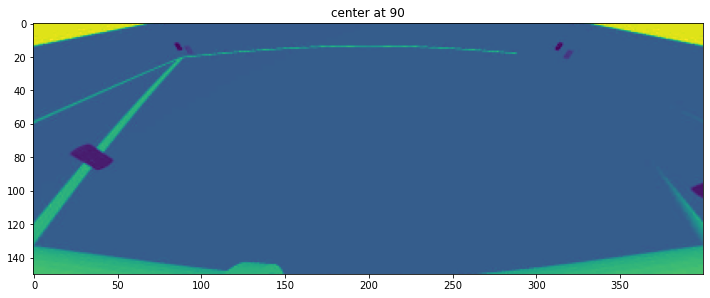

In [1]:
import numpy as np
import cv2
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy.interpolate import interp2d
from numpy.linalg import inv
import time
import argparse

frame                 =  cv2.cvtColor(cv2.imread('image/left_gs72_ideal.jpg'),cv2.COLOR_BGR2GRAY) 
steps                 =  1000
pix4unit              =  (1/(steps/2)) 
u0,v0                 = (steps/2) , (steps/2)
f_vir, sx_vir, sy_vir =  0.1, 0.0005, 0.0005 #f = virtual focal lenght---#sx = pix_size_u---#sy = pix_size_v
width_vir, height_vir =  400,150
roll, pitch           =  0,0
#----------------------------------------------------------------------------------------FIRST INTERPOLATION FOR WRAPPING
x = np.linspace(0, steps, steps) # y will be equal to x (squared image) so we will use x,x instead x,y below
inter_frame = interp2d(x,x,frame,kind='linear',fill_value='-1')  
#//////////////////////////////////////////////////////////////////////////////////////////////////////VIRTUAL CAM CONFIG
u0_vir,v0_vir =  (width_vir/2), (height_vir/2)
k_vir         =  np.array([[f_vir/sx_vir,0,u0_vir],[0,f_vir/sy_vir,v0_vir],[0,0,1]]) #VIRTUAL CAMERA MATRIX
k_vir_inv     =  inv(k_vir)                                                          #VIRTUAL CAMERA INVERSE MATRIX


#TESTED AND WORKING//////////////////////////////////////////////////////////////////////////////////////////////////////////////////

def wrap_grid(k_vir_inv, roll, pitch, width_vir, height_vir, u0, v0, pix4unit ):
    
    r2d  = (180/np.pi)  #constant =57.3 --- 1 rad=57.3 deg or 180/pi
    
    #rotation along x axis and y axis only, roll_mtx * pitch_mtx equal to the matrix shown below
    rot  = np.array([[np.cos(pitch/r2d),                           0,                 np.sin(pitch/r2d)],
                     [(np.sin(pitch/r2d))*(np.sin(roll/r2d)),      np.cos(roll/r2d),  (-1)*(np.cos(pitch/r2d))*(np.sin(roll/r2d))],
                     [(-1)*(np.sin(pitch/r2d))*(np.cos(roll/r2d)), np.sin(roll/r2d),  np.cos(pitch/r2d)*np.cos(roll/r2d) ]])

    coord=np.zeros([width_vir, height_vir,2],float) #retrieved coordinates. layer(:,:,0) stores u values --- layer(:,:,1) stores v values 
    
    for u in range (0, width_vir):
        for v in range (0, height_vir):
            
            v_im_cor      = np.matmul(k_vir_inv, np.array([[u],[v],[1]])) #coordinate in r3 = k_vir_inverse*coord of the pixel in the virtual image(in the im plane)             
            
            v_im_cor      = np.matmul(rot, v_im_cor)                         #coordinates rotated along x and y axis, roll and pitch rotation
       
            mod =  np.sqrt(( np.power(v_im_cor[0],2) ) + ( np.power(v_im_cor[1],2) ) + ( np.power(v_im_cor[2],2) ) )  

            v_im_cor_unit = v_im_cor/mod
            
            v_im_cor_unit = v_im_cor/mod
                     
            
            coord[u,v,0] =  v_im_cor_unit[0] / pix4unit + u0
            coord[u,v,1] =  v_im_cor_unit[1] / pix4unit + v0  
              
    return coord
#------------------------------------------------------------------------------------------------------------------------------------
#TESTED AND WORKING//////////////////////////////////////////////////////////////////////////////////////////////////////////////////

def remap_pixels(inter_frame, coord, width_vir, height_vir):
    
    v_im = np.zeros([width_vir, height_vir],float)
    
    for u in range (0, width_vir):
        for v in range (0, height_vir):
            
            x,y = coord[u,v,0], coord[u,v,1] #cause x = layer(:,:,0) that stores u values AND y = layer(:,:,1) that stores v values 
            
            v_im[u,v] = inter_frame(x,y)
    
    return v_im
#------------------------------------------------------------------------------------------------------------------------------------

coord = wrap_grid(k_vir_inv, roll, pitch, width_vir, height_vir, u0, v0, pix4unit)     


t2 = time.time()
v_img = remap_pixels(inter_frame, coord, width_vir, height_vir)


elapsed = time.time() - t2
print('\n'+'TIME TO DEPLOY WARPING:'+'\n'+ str(elapsed)+' '+'s' +'\n'+'---------------------' )   

fig, (ax1) = plt.subplots(1,1, figsize = (12, 12),  sharey=False)
ax1.set_title('center at 90')
x  = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)#delta elevation is the circle touching the 4 corners of the v_image square as a lens, image 
ax1.imshow(np.transpose(v_img)) 